In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Menyiapkan Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Memuat Data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/latih',  # Path data pelatihan
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=True  # Data dilatih dengan shuffle
)

validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/validasi',  # Path data validasi
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=False  # Validasi tidak perlu shuffle
)

# 3. Membuat Model dengan Transfer Learning (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan beberapa layer pertama base model (misalnya sampai layer ke-100)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Membebaskan beberapa layer terakhir untuk fine-tuning
for layer in base_model.layers[100:]:
    layer.trainable = True

# Membangun model dengan lapisan tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahkan regularisasi L2
x = Dropout(0.5)(x)  # Regularisasi dropout
x = Dense(10, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas

# Final model
model = Model(inputs=base_model.input, outputs=x)

# 4. Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# 5. Melatih Model
# 5. Melatih Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # Jumlah epoch tetap
)

# Menyimpan Model
# Menentukan versi model
version = 7
model_filename = f'model_v{version}.h5'

# Menyimpan model
model.save(model_filename)
print(f"Model disimpan ke: {model_filename}")

Found 1920 images belonging to 10 classes.
Found 480 images belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,026,698 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1296s 21s/step - accuracy: 0.3628 - loss: 4.3433 - val_accuracy: 0.8646 - val_loss: 2.7122
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 693ms/step - accuracy: 0.8918 - loss: 2.6687 - val_accuracy: 0.9187 - val_loss: 2.4757
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 694ms/step - accuracy: 0.9626 - loss: 2.3413 - val_accuracy: 0.9146 - val_loss: 2.3670
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 699ms/step - accuracy: 0.9849 - loss: 2.1785 - val_accuracy: 0.9417 - val_loss: 2.1952
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 699ms/step - accuracy: 0.9844 - loss: 2.0750 - val_accuracy: 0.9479 - val_loss: 2.0791
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.9873 - loss: 1.9662 - val_accuracy: 0.9521 - val_loss: 1.9819
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 696ms/step - accuracy: 0.9879 - loss: 1.8660 - val_accuracy: 0.9792 - val_loss: 1.8138
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 695ms/step - accuracy: 0.9945 - loss: 1.7495 - val_accu

Model disimpan ke: model_v7.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9742 - loss: 1.5373
Validation Loss: 1.5283
Validation Accuracy: 0.9812
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step


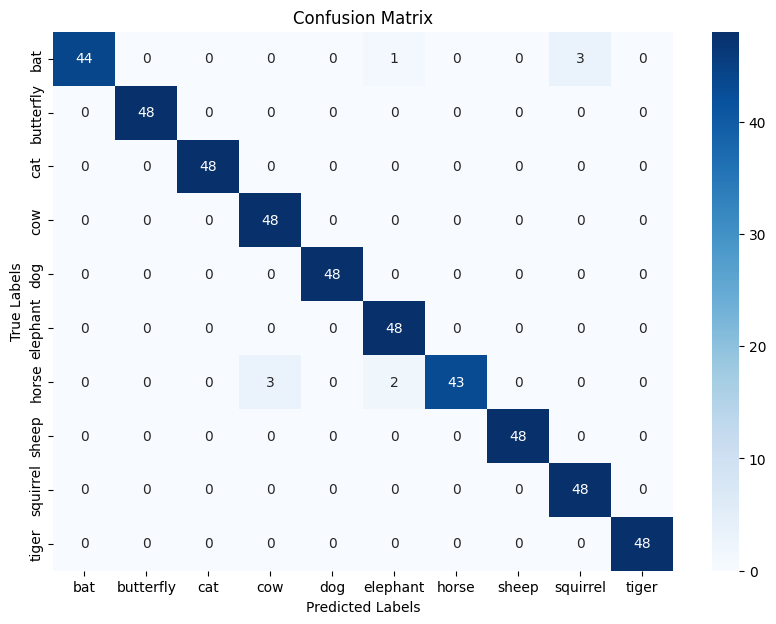

Classification Report:
              precision    recall  f1-score   support

         bat     1.0000    0.9167    0.9565        48
   butterfly     1.0000    1.0000    1.0000        48
         cat     1.0000    1.0000    1.0000        48
         cow     0.9412    1.0000    0.9697        48
         dog     1.0000    1.0000    1.0000        48
    elephant     0.9412    1.0000    0.9697        48
       horse     1.0000    0.8958    0.9451        48
       sheep     1.0000    1.0000    1.0000        48
    squirrel     0.9412    1.0000    0.9697        48
       tiger     1.0000    1.0000    1.0000        48

    accuracy                         0.9812       480
   macro avg     0.9824    0.9812    0.9811       480
weighted avg     0.9824    0.9812    0.9811       480

Error Rate: 0.0188


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Mengevaluasi Model dengan Dataset Validasi
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 2. Mendapatkan Prediksi dan Label Asli
y_true = validation_generator.classes  # Label sebenarnya
y_pred_prob = model.predict(validation_generator, verbose=1)  # Prediksi probabilitas
y_pred = np.argmax(y_pred_prob, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# 3. Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Menampilkan Confusion Matrix Berwarna
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 5. Menghasilkan Laporan Klasifikasi (Precision, Recall, F1 Score)
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report:")
print(report)

# 6. Menghitung Error Rate
error_rate = 1 - val_accuracy
print(f"Error Rate: {error_rate:.4f}")

In [4]:
from ipywidgets import FileUpload, Image, VBox
from PIL import Image as PILImage
import io
import numpy as np
import tensorflow as tf

# Daftar kelas yang sesuai dengan model Anda
class_names = ['bat', 'butterfly', 'cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'squirrel', 'tiger']

# Load model (gunakan model Anda sendiri)
model = tf.keras.models.load_model('/content/model_v7.h5')

# Membuat widget untuk mengupload file
upload = FileUpload(accept='image/*', multiple=False)

# Membuat widget Image untuk menampilkan gambar dengan ukuran tampilan yang disesuaikan
image_widget = Image()

# Fungsi untuk memproses gambar setelah diupload
def process_uploaded_image(change):
    # Mendapatkan file yang diupload
    img_data = next(iter(upload.value.values()))['content']

    # Membuka gambar dengan PIL
    img = PILImage.open(io.BytesIO(img_data))

    # Menampilkan gambar yang diupload pada widget
    img_resized = img.resize((400, 400))  # Mengubah ukuran gambar sesuai keinginan
    img_bytes = io.BytesIO()
    img_resized.save(img_bytes, format='PNG')
    img_bytes.seek(0)

    image_widget.value = img_bytes.read()  # Update widget image dengan gambar yang sudah diubah ukurannya
    image_widget.width = 300  # Atur lebar tampilan gambar
    image_widget.height = 300  # Atur tinggi tampilan gambar

    # Mengubah ukuran gambar sesuai input model (224x224)
    img_resized_for_model = img.resize((224, 224))

    # Mengubah gambar menjadi array numpy
    img_array = np.array(img_resized_for_model)

    # Menambah dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi (sesuai dengan model yang digunakan)
    img_array = img_array / 255.0

    # Melakukan prediksi
    classes = model.predict(img_array)

    # Mengidentifikasi kelas berdasarkan prediksi
    predicted_class = np.argmax(classes, axis=1)

    # Menampilkan nama kelas prediksi
    predicted_class_name = class_names[predicted_class[0]]
    print(f'Predicted Class: {predicted_class_name}')

# Menyambungkan fungsi dengan upload event
upload.observe(process_uploaded_image, names='value')

# Tampilkan widget upload dan gambar
display(VBox([upload, image_widget]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: butterfly
